# Recommendation Systems Assignment

### MIE 1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a2a22cf1671415cfc7da68ca10cf6da4bd4f8077fcd09423f37a62db72081444
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE1513HS-2022/course-datasets/raw/main/ml-100k.zip", "ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [7]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [8]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [9]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [10]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########

    # Initialize a of size (num_users, num_items) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
        
    ###########         end         ###########
    return matrix

### (b)

In [11]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [12]:
popularity_recsys = BaseLineRecSys('popularity')

In [13]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [14]:
x = popularity_recsys.getModel()

In [16]:
np.all(x<=1)

True

In [17]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [18]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:04, 4050.04it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [19]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [20]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [21]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [22]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3405.02it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [23]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric='manhattan'))
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)

        # Initialize the predicted rating matrix with zeros
        # temp_matrix is a UxI matrix
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        
        if self.base == 'user':
            ########### your code goes here ###########
            
            # uu_similarity = UxU matrix (take train_matrix[UxI] as parameter)
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5

            #predictionMatrix is a UxI matrix - UxU mul UxI
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)

            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            #ii_similarity = IxI matrix (take the transpose of train_matrix[IxU matrix] as parameter)
            ii_similarity = self.method(np.transpose(train_matrix))
            # UxI: UxI mul IxI
            normalizer = np.matmul(temp_matrix, ii_similarity)
            normalizer[normalizer == 0] = 1e-5

            #predictionMatrix is a UxI matrix - UxI mul IxI
            predictionMatrix = np.matmul(train_matrix, ii_similarity)/normalizer
            
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)

            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [24]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [26]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Cosine similarity works better than euclidean distance. Cosine similarity measures the cosine of the angle between the vectors, so it is a judgment of orientation and not magnitude.

### (b)

Since Manhattan distance is more preferable for high dimensional applications compared to other similarity metrics. Besides for a large user-item matrix, it takes fewer steps on computation.

## Q3

### (a)

In [27]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [28]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [29]:
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [30]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [31]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:10, 1840.69it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [32]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [33]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [34]:
item_cosine_recsys.getModel()

array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [35]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3955.77it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)

In [36]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [popularity_recsys, 
#                       average_user_rating_recsys, 
#                       user_cosine_recsys]

algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
# cv_patk = CrossValidation('P@K')
cv_rmse = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm user-cosine


20000it [00:05, 3612.44it/s]
20000it [00:05, 3641.16it/s]
20000it [00:05, 3959.32it/s]
20000it [00:05, 3421.24it/s]
20000it [00:05, 3934.45it/s]


Processing algorithm item-cosine


20000it [00:05, 3377.82it/s]
20000it [00:04, 4006.54it/s]
20000it [00:06, 3071.27it/s]
20000it [00:04, 4017.07it/s]
20000it [00:06, 3319.26it/s]


{'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'item-cosine': [[1.0334307063086856,
   1.0169957595085215,
   1.0045122531086308,
   1.0099161642550833,
   1.0111907186985918],
  1.0152091203759024,
  1.0014131747526513,
  1.0290050659991534]}

RMSE results:

user-user collaborative filtering for cosine similarity:
  1. average: 1.0173541216605808
  2. confidence interval: [1.009013080226148, 1.0256951630950135]

item-item collaborative filtering for cosine similariry:
  1. average: 1.0152091203759024
  2. confidence interval: [1.0014131747526513, 1.0290050659991534]

By comparing the average of RMSE results, the item-item collaborative filtering has a lower score. Thus item-cosine performed better than user-cosine. This may because the amount of items is larger than amount of users, so item-item matrix is larger than user-user matrix. Hence item-item collaborative filtering is less affected by sparsity because it calculates similarities based on the average ratings of all users, and this leads to a better performance with a higher accuracy.

## Q4

### (a)

In [ ]:
algorithm_instances_all = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

# RMSE, P@K, RPrecision

cv_patk = CrossValidation('P@K')
cv_rmse = CrossValidation('RMSE')
cv_rpre = CrossValidation('RPrecision')

patk_result = cv_patk.run(algorithm_instances_all,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
rmse_result = cv_rmse.run(algorithm_instances_all,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)
rpre_result = cv_rpre.run(algorithm_instances_all,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

In [ ]:

df1 = pd.DataFrame(columns=["P@k:Average", "P@k:CI"])
for key in patk_result:
  df1.loc[key] = [patk_result[key][1], [patk_result[key][2], patk_result[key][3]]]

df2 = pd.DataFrame(columns=["RMSE:Average", "RMSE:CI"])
for key in rmse_result:
  df2.loc[key] = [rmse_result[key][1], [rmse_result[key][2], rmse_result[key][3]]]

df3 = pd.DataFrame(columns=["RPrecision:Average", "RPrecision:CI"])
for key in rpre_result:
  df3.loc[key] = [rpre_result[key][1], [rpre_result[key][2], rpre_result[key][3]]]

df = pd.merge(df1, df2, left_index=True, right_index=True)
df_final = pd.merge(df, df3, left_index=True, right_index=True)
df_final

,P@k:Average,P@k:CI,RMSE:Average,RMSE:CI,RPrecision:Average,RPrecision:CI
popularity,0.550583,"[0.40544114481568705, 0.6957253451100839]",3.159093,"[3.139292746995387, 3.1788930349826354]",0.717666,"[0.7068236314882174, 0.7285092697223478]"
useraverage,0.473637,"[0.3419993013451059, 0.6052753540101459]",1.043718,"[1.0289303496379316, 1.0585049626810734]",0.645730,"[0.6396305850946756, 0.6518303989547497]"
user-cosine,0.555843,"[0.40959849499983714, 0.7020876131655943]",1.017354,"[1.009013080226148, 1.0256951630950135]",0.721019,"[0.7099951520220996, 0.7320424286999921]"
item-cosine,0.532216,"[0.3837005215009889, 0.6807321402169354]",1.015209,"[1.0014131747526513, 1.0290050659991534]",0.708035,"[0.7007109490697986, 0.7153589032487796]"


### (b)

popularity baseline does not make any predictions of ratings. It simply recommends the same popular items to all users. Therefore, there are no predicted ratings to compare to actual ratings, so popularity baseline could not be evaluated by RMSE metrics.

### (c)

For RMSE, item-cosine performed the best (lowest RMSE score). This may because the amount of item rating is large, so more features can be used on prediction. Also many users may have the similar opinion on the same item. Hence the accuracy of prediction is the highest.


For Precision at k and RPrecision, user-cosine perfromed best (highest score). Compared to popularity and average rating, cosine similarity could tailor to individuals (recommend based on individual taste). Hence cosine similariry has a better performance. Besides, user-user matrix is smaller than item-item matrix, so it may have lower pobability to get a high false positive or false negative rate.

### (d)

No. RMSE measures the difference between predicted value and actual value. It does not directly measure the quality of the ranking of recommendations. A good performance on RMSE may lead to good ranking metrics, but it's not always the case. (may perform well in predicting ratings but poor quality recommendations in ranking order)

## Q5

### (a)

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

pd.set_option('display.max_rows', None)
moviesDF[["movieTitle", "movieID"]]

In [101]:
train_matrix = dataPreprocessor(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
ii_similarity = 1 - pairwise_distances(np.transpose(train_matrix), metric='cosine')

# ID - movies
# 263 - steel, 592 - true crime, 1092 - Dear God
movie_id = [263, 592, 1092]
for id in movie_id:
  top5 = np.argsort(ii_similarity[:,id-1])[-6:-1][::-1]
  print('')
  print("Similar movies for", moviesDF.iloc[id-1]["movieTitle"], ":")
  for movie in top5:
    print(moviesDF.at[movie, "movieID"], moviesDF.at[movie, "movieTitle"])



Similar movies for Steel (1997) :
1295 Kicked in the Head (1997)
1617 Hugo Pool (1997)
1612 Leading Man, The (1996)
1293 Star Kid (1997)
680 Kull the Conqueror (1997)

Similar movies for True Crime (1995) :
677 Fire on the Mountain (1996)
600 Daniel Defoe's Robinson Crusoe (1996)
593 Stalingrad (1993)
1189 Prefontaine (1997)
1594 Everest (1998)

Similar movies for Dear God (1996) :
1603 Angela (1995)
918 City of Angels (1998)
1438 Panther (1995)
139 Love Bug, The (1969)
1337 Larger Than Life (1996)


### (b)

Yes, we could check if they are similar genres of movies, or have the same actors, or check the similarity of actual reviews of these movies etc. If we could find similarities among movies on the list, then we can conclude the recommendations performed well.

## Q6

### (a)

In [77]:
trainUI = dataPreprocessor(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
numrat = []
for user in range(trainUI.shape[0]):
  total = 0
  for i in trainUI[user]:
    if i != 0:
      total += 1
  numrat.append(total)


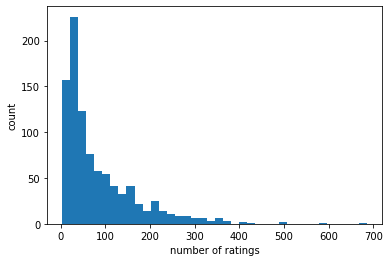

In [84]:
plt.hist(numrat, bins = 'auto')
plt.ylabel("count")
plt.xlabel("number of ratings")
plt.show()

set threshold = 100. number of ratings is less or equal to 100 is considered as few ratings, otherwise it is considered as a moderate to large ratings.

In [121]:
newtrainUI = pd.DataFrame(data = trainUI)
newtrainUI['count'] = numrat
newtrainUI['id'] = list(range(1,trainUI.shape[0]+1))

largerating = newtrainUI[newtrainUI["count"] > 100]
fewrating = newtrainUI[newtrainUI["count"] <= 100]

In [124]:
large_train = rating_df_train[rating_df_train["userID"].isin(largerating.id.unique())]
few_train = rating_df_train[rating_df_train["userID"].isin(fewrating.id.unique())]

In [102]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [126]:
user_large = SimBasedRecSys('user','cosine')
user_few = SimBasedRecSys('user','cosine')

item_large = SimBasedRecSys('item','cosine')
item_few = SimBasedRecSys('item','cosine')

In [ ]:
user_large.predict_all(large_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
user_few.predict_all(few_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

item_large.predict_all(large_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_few.predict_all(few_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [132]:
print("user_cosine for large ratings (>100):", rmse(user_large.getModel(), dataPreprocessor(large_train,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))
print("user_cosine for few ratings (<=100):", rmse(user_few.getModel(), dataPreprocessor(few_train,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

print("item_cosine for large ratings (>100):", rmse(item_large.getModel(), dataPreprocessor(large_train,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))
print("item_cosine for few ratings (<=100):", rmse(item_few.getModel(), dataPreprocessor(few_train,len(rating_df.userID.unique()), len(rating_df.itemID.unique()))))

user_cosine for large ratings (>100): 0.9256760984801848
user_cosine for few ratings (<=100): 0.8584272943919309
item_cosine for large ratings (>100): 0.9865740029310182
item_cosine for few ratings (<=100): 0.8745022792849302


By comparing the results of user-user and item-item collaborative filtering, the performance on fewer rating items are better. (0.85 vs 0.92, 0.87 vs 0.98). The overall performance of user-user collaborative filtering on fewer ratings is the best. (lowest RMSE score) 

This is probably because users with fewer ratings on movies tend to review certain types of movie,so their tastes are more likely to specialized. Therefore it is easier to find other users with the similar interest, and it is also easier to find movies have similarities.

# Validation

In [133]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [134]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [135]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [136]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [137]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [138]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [139]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [140]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [141]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [142]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [143]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [144]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [145]:
validateUUSimBasedRecSys()

<ipython-input-23-5891f91cbc2c>:95: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


### Item-Item Similarity Based Recommendation System

In [146]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [147]:
validateIISimBasedRecSys()

<ipython-input-23-5891f91cbc2c>:116: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
